# Twitter Sentiment Analysis

In [1]:
'''!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade'''

'!pip install gensim --upgrade\n!pip install keras --upgrade\n!pip install pandas --upgrade'

In [2]:
# DataFrame
import pandas as pd
import gc
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [5]:
dataset_filename = os.listdir("../input")[0]
#dataset_path = '../input/sentiment140/training.1600000.processed.noemoticon.csv'
dataset_path = '../input/sentiment140/training.1600000.processed.noemoticon.csv'
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../input/sentiment140/training.1600000.processed.noemoticon.csv


In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 744 ms, sys: 36 ms, total: 780 ms
Wall time: 780 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

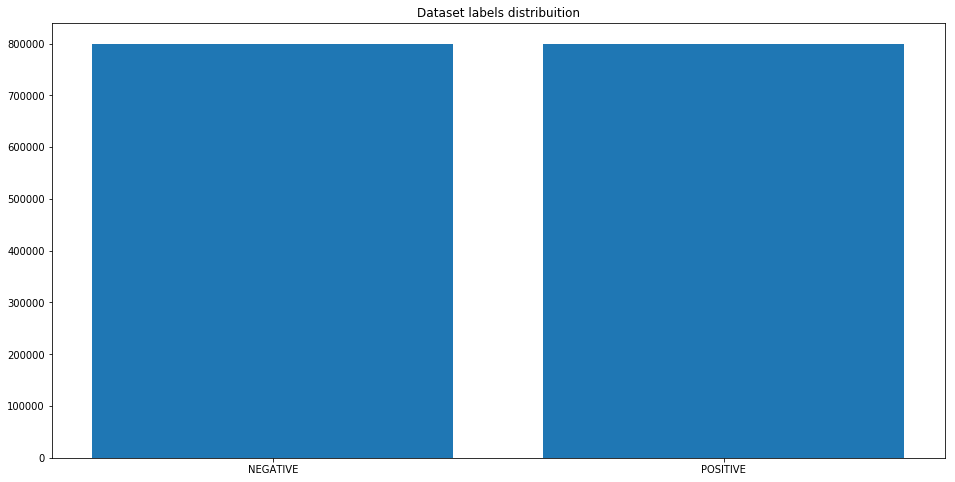

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 57.5 s, sys: 220 ms, total: 57.7 s
Wall time: 57.8 s


### Split train and test

In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [15]:
%%time
documents = [_text.split() for _text in df_train.text] 
import os
model_exists = os.path.isfile('../input/trained-model/model.w2v')

CPU times: user 3.76 s, sys: 320 ms, total: 4.08 s
Wall time: 4.08 s


In [16]:
if model_exists:
    from gensim.models import Word2Vec
    w2v_model=Word2Vec.load("../input/trained-model/model.w2v")
    print("w2v model exists, existing model loaded.")
else:
    w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

w2v model exists, existing model loaded.


In [17]:
'''if model_present:
    w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                                window=W2V_WINDOW, 
                                                min_count=W2V_MIN_COUNT, 
                                                workers=8)'''

'if model_present:\n    w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, \n                                                window=W2V_WINDOW, \n                                                min_count=W2V_MIN_COUNT, \n                                                workers=8)'

In [18]:
if not model_exists:
    w2v_model.build_vocab(documents)

In [19]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [20]:
w2v_model.wv['model'].shape

(300,)

In [21]:
%%time
if model_exists==False:
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
else:
    print("Trained model loaded")

Trained model loaded
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 103 µs


In [22]:
w2v_model.most_similar("love")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5732780694961548),
 ('loves', 0.5623787045478821),
 ('loved', 0.5373271703720093),
 ('amazing', 0.5026600360870361),
 ('adore', 0.4942743480205536),
 ('looove', 0.47235167026519775),
 ('awesome', 0.4598265290260315),
 ('lovee', 0.45823752880096436),
 ('loveee', 0.4531649351119995),
 ('loooove', 0.44260522723197937)]

### Tokenize Text

In [23]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 25.4 s, sys: 204 ms, total: 25.6 s
Wall time: 25.5 s


In [24]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

CPU times: user 38.4 s, sys: 1.02 s, total: 39.4 s
Wall time: 39.5 s


### Label Encoder 

In [25]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [26]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [27]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [28]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [29]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [30]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=W2V_SIZE, trainable=False)

In [31]:
print(vocab_size,W2V_SIZE,SEQUENCE_LENGTH)

290419 300 300


### Build Model

In [32]:
model_exists=os.path.isfile('../input/trained-model/model.h5')
if model_exists:
    from keras.models import load_model
    model = load_model('../input/trained-model/model.h5')
    print("Keras model file found and loaded.")
else:
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

model.summary()

Keras model file found and loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [33]:
if not model_exists:
    model.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
else:
    print("Compiled Model Loaded.")

Compiled Model Loaded.


### Callbacks

In [34]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [35]:
%%time
if not model_exists:#if model doesn't exist, fit the model on the training set
    from keras.callbacks import CSVLogger

    csv_logger = CSVLogger('training.log', separator=',', append=False)
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    #storing history for visualization
    pickle_out = open("../input/trained-model/history.pickle","wb")
    pickle.dump(history.histpry, pickle_out)
    pickle_out.close()
else:
    if os.path.isfile('../input/trained-model/history.pickle'):
        history=pickle.load('../input/trained-model/history.pickle')
        print("History file found and loaded.")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 837 µs


### Evaluate

In [36]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 82s 258us/step

ACCURACY: 0.791134375
LOSS: 0.4442952784538269
CPU times: user 1min 51s, sys: 16.1 s, total: 2min 7s
Wall time: 1min 22s


In [37]:
try:
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
except:
    print("Fit history not found, so visualizations are not shown.")

Fit history not found, so visualizations are not shown.


### Predict

In [38]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [39]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [40]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9656286239624023,
 'elapsed_time': 0.4495675563812256}

In [41]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.010753681883215904,
 'elapsed_time': 0.2817261219024658}

In [42]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.2742375433444977,
 'elapsed_time': 0.24402117729187012}

### Confusion Matrix

In [43]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 22s 68us/step
CPU times: user 17.3 s, sys: 2.27 s, total: 19.6 s
Wall time: 22.3 s


In [44]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

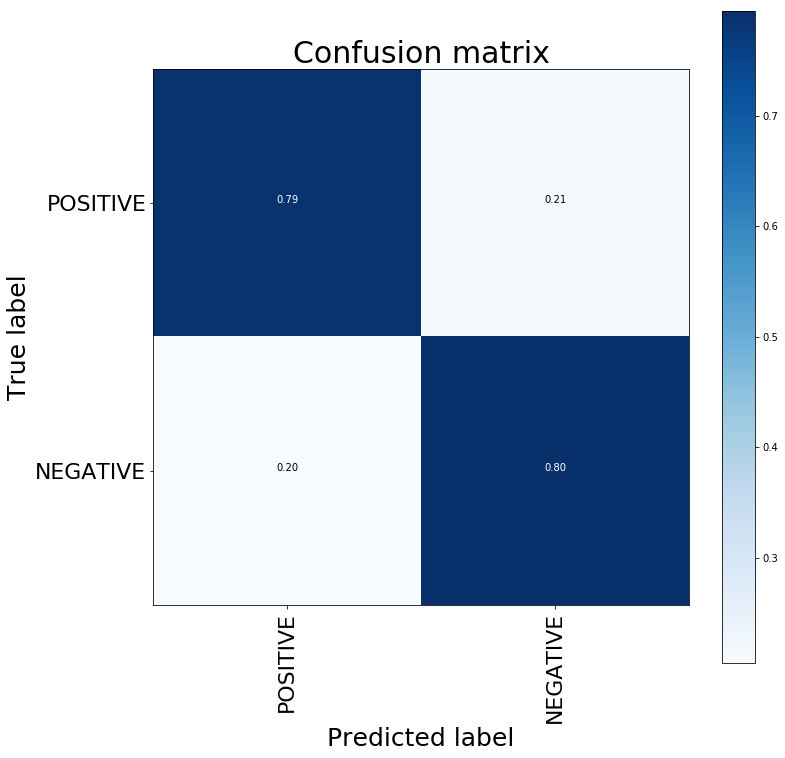

CPU times: user 1.33 s, sys: 252 ms, total: 1.58 s
Wall time: 1.34 s


In [45]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [46]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [47]:
accuracy_score(y_test_1d, y_pred_1d)

0.791134375

### Save model

In [48]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [49]:
predict("lol")

{'label': 'POSITIVE',
 'score': 0.7820382714271545,
 'elapsed_time': 0.7218623161315918}

In [50]:
tweets=pd.read_csv('../input/twitterdiamond/diamond.csv')

In [51]:
tweets=tweets.rename(columns={'7:50 pm - 23 May 2019':'Time','This guy told not celebrate the #PulwamaAttack has it hurts  some community  Now people answered him of giving   seat and a defeat of his father and son  Karma hits you  badly  pic twitter com rx eO CK P':'Tweet'})

In [52]:
#!pip install --upgrade pip
import warnings
warnings.filterwarnings("ignore")
tweets.head()

,Time,Tweet
0,5:22 am - 24 May 2019,India should be prepared for another attack ju...
1,11:40 pm - 20 May 2019,Dear Sir rajnathsingh looks like our police...
2,11:33 am - 24 May 2019,republic ELECTIONS are over #PulwamaAttack is...
3,11:43 am - 23 May 2019,republic #PulwamaAttack still not completely ...
4,9:44 am - 23 May 2019,Are you sure We DON T have WAR between OUR co...


In [53]:
'''pclass=[]
score=[]
count=0
for i in tweets['Tweet']:
    p=predict(i)
    pclass.append(p['label'])
    score.append(p['score'])
    if count%100==0 or count==0:
        print("Tweets done:",count)
    count+=1'''

'pclass=[]\nscore=[]\ncount=0\nfor i in tweets[\'Tweet\']:\n    p=predict(i)\n    pclass.append(p[\'label\'])\n    score.append(p[\'score\'])\n    if count%100==0 or count==0:\n        print("Tweets done:",count)\n    count+=1'

In [54]:
#tweets["Class"]=pclass
#tweets['Predicted Class Score']=score

In [55]:
tweets.head()

,Time,Tweet
0,5:22 am - 24 May 2019,India should be prepared for another attack ju...
1,11:40 pm - 20 May 2019,Dear Sir rajnathsingh looks like our police...
2,11:33 am - 24 May 2019,republic ELECTIONS are over #PulwamaAttack is...
3,11:43 am - 23 May 2019,republic #PulwamaAttack still not completely ...
4,9:44 am - 23 May 2019,Are you sure We DON T have WAR between OUR co...


In [56]:
'''from IPython.display import HTML
import base64
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)'''

'from IPython.display import HTML\nimport base64\ndef create_download_link(df, title = "Download CSV file", filename = "data.csv"):  \n    csv = df.to_csv()\n    b64 = base64.b64encode(csv.encode())\n    payload = b64.decode()\n    html = \'<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>\'\n    html = html.format(payload=payload,title=title,filename=filename)\n    return HTML(html)'

In [57]:
#create_download_link(tweets)

Creating Bidirectional LSTM Model

In [58]:
#in development

model_exists=os.path.isfile('../input/model-with-dropout/bidirectional_model(with dropout).h5')
if model_exists:
    from keras.models import load_model
    model = load_model('../input/model-with-dropout/bidirectional_model(with dropout).h5')
    print("Keras model file found and loaded.")
else:
    import keras
    from keras.layers import Lambda
    import tensorflow as tf
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    #model.add(Flatten())
    #model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))
    #model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))
    #model.add(keras.layers.Bidirectional((keras.layers.CuDNNLSTM(100,(3,3),padding='same',input_shape=(300,300), dropout=0.2, recurrent_dropout=0.2))))
    model.add(keras.layers.Bidirectional((keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))))
    #model.add(keras.layers.ConvLSTM2D(100, (3,3), strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, return_sequences=False, go_backwards=False, stateful=False, dropout=0.0, recurrent_dropout=0.0))
    model.add(Dense(1, activation='sigmoid'))

model.summary()

Keras model file found and loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 87,446,701
Trainable params: 321,001
Non-trainable params: 87,125,700
_________________________________________________________________


In [59]:
predict('The concert was boring for the first 15 minutes while the band warmed up but then was terribly exciting')

{'label': 'NEGATIVE',
 'score': 0.3633217513561249,
 'elapsed_time': 1.0050992965698242}

In [60]:
if not model_exists:
    model.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
else:
    print("Compiled Model Loaded.")

Compiled Model Loaded.


In [61]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Train

In [62]:
%%time
if not model_exists:#if model doesn't exist, fit the model on the training set
    from keras.callbacks import CSVLogger

    csv_logger = CSVLogger('training.log', separator=',', append=False)
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    #storing history for visualization
    pickle_out = open("../input/trained-model/convhistory.pickle","wb")
    pickle.dump(history.histpry, pickle_out)
    pickle_out.close()
'''else:
    if os.path.isfile('../input/trained-model/convhistory.pickle'):
        history=pickle.load('../input/trained-model/convhistory.pickle')
        print("History file found and loaded.")'''

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 24.6 µs


'else:\n    if os.path.isfile(\'../input/trained-model/convhistory.pickle\'):\n        history=pickle.load(\'../input/trained-model/convhistory.pickle\')\n        print("History file found and loaded.")'

In [63]:
model.save('bidirectional_model.h5')

Confusion Matrix

In [64]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 39s 122us/step
CPU times: user 38 s, sys: 9 s, total: 47 s
Wall time: 39.5 s


In [65]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

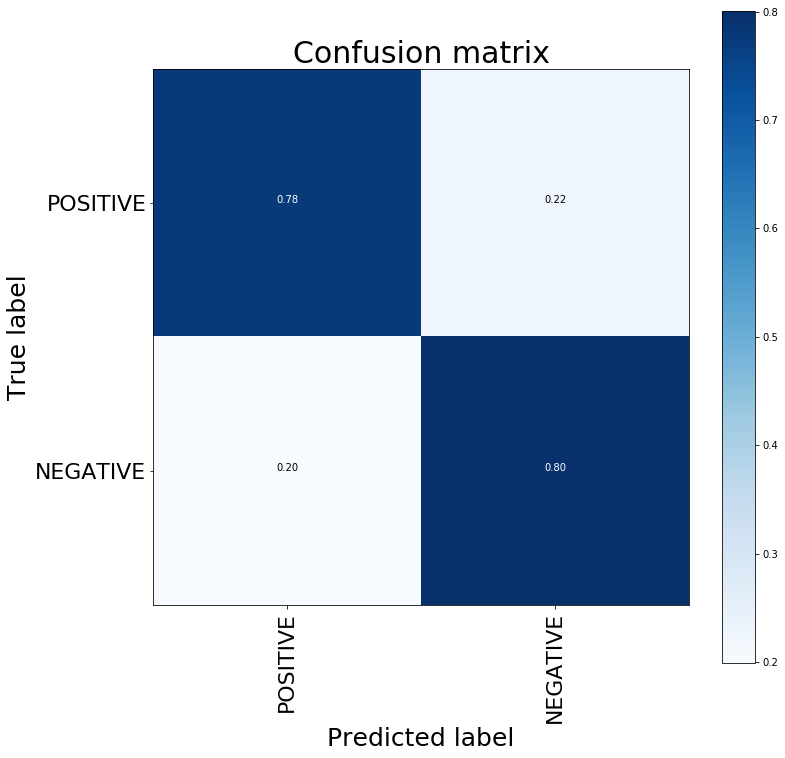

CPU times: user 1.34 s, sys: 220 ms, total: 1.56 s
Wall time: 1.33 s


In [66]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [67]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79    159494
    POSITIVE       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [68]:
'''%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])'''

'%%time\nscore = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)\nprint()\nprint("ACCURACY:",score[1])\nprint("LOSS:",score[0])'

Convolutional LSTM

In [69]:
# in development
'''
model_exists=os.path.isfile('../input/model-with-dropout/conv_model.h5')
if model_exists:
    from keras.models import load_model
    model = load_model('../input/model-with-dropout/conv_model.h5')
    print("Keras model file found and loaded.")
else:
    import keras
    from keras.layers import Lambda
    import tensorflow as tf
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    #model.add(Flatten())
    model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))
    model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))
    #model.add(keras.layers.Bidirectional((keras.layers.CuDNNLSTM(100,(3,3),padding='same',input_shape=(300,300), dropout=0.2, recurrent_dropout=0.2))))
    model.add(keras.layers.ConvLSTM2D(100,(3,3),padding='same',strides=1, dropout=0.2, recurrent_dropout=0.2,))
    #model.add(keras.layers.ConvLSTM2D(100, (3,3), strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, return_sequences=False, go_backwards=False, stateful=False, dropout=0.0, recurrent_dropout=0.0))
    #model.add(keras.layers.Reshape((300,100)))
    #model.add(Flatten())
    #model.add(Dense(100,activation='sigmoid'))
    model.add(Dense(1,activation='relu'))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    


model.summary()'''

'\nmodel_exists=os.path.isfile(\'../input/model-with-dropout/conv_model.h5\')\nif model_exists:\n    from keras.models import load_model\n    model = load_model(\'../input/model-with-dropout/conv_model.h5\')\n    print("Keras model file found and loaded.")\nelse:\n    import keras\n    from keras.layers import Lambda\n    import tensorflow as tf\n    model = Sequential()\n    model.add(embedding_layer)\n    model.add(Dropout(0.5))\n    #model.add(Flatten())\n    model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))\n    model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))\n    #model.add(keras.layers.Bidirectional((keras.layers.CuDNNLSTM(100,(3,3),padding=\'same\',input_shape=(300,300), dropout=0.2, recurrent_dropout=0.2))))\n    model.add(keras.layers.ConvLSTM2D(100,(3,3),padding=\'same\',strides=1, dropout=0.2, recurrent_dropout=0.2,))\n    #model.add(keras.layers.ConvLSTM2D(100, (3,3), strides=(1, 1), padding=\'valid\', data_format=None, dilation_rate=(1, 

In [70]:
'''# in development

model_exists=os.path.isfile('../input/model-with-dropout/conv_model.h5')
if model_exists:
    from keras.models import load_model
    model = load_model('../input/model-with-dropout/conv_model.h5')
    print("Keras model file found and loaded.")
else:
    import keras
    from keras.layers import Lambda
    import tensorflow as tf
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    #model.add(Flatten())
    #model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))
    #model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))
    #model.add(keras.layers.Bidirectional((keras.layers.CuDNNLSTM(100,(3,3),padding='same',input_shape=(300,300), dropout=0.2, recurrent_dropout=0.2))))
    #model.add(keras.layers.ConvLSTM2D(100,(3,3),padding='same',strides=1, dropout=0.2, recurrent_dropout=0.2,))
    #model.add(keras.layers.ConvLSTM2D(100, (3,3), strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, return_sequences=False, go_backwards=False, stateful=False, dropout=0.0, recurrent_dropout=0.0))
    model.add(keras.layers.Conv1D(32, 3, strides=1, padding='valid',activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=None, padding='valid'))
    model.add(keras.layers.Bidirectional((keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))))
    #model.add(keras.layers.Reshape((300,100)))
    #model.add(Flatten())
    #model.add(Dense(100,activation='sigmoid'))
    #model.add(Dense(1,activation='relu'))
    #model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    


model.summary()'''

'# in development\n\nmodel_exists=os.path.isfile(\'../input/model-with-dropout/conv_model.h5\')\nif model_exists:\n    from keras.models import load_model\n    model = load_model(\'../input/model-with-dropout/conv_model.h5\')\n    print("Keras model file found and loaded.")\nelse:\n    import keras\n    from keras.layers import Lambda\n    import tensorflow as tf\n    model = Sequential()\n    model.add(embedding_layer)\n    model.add(Dropout(0.5))\n    #model.add(Flatten())\n    #model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))\n    #model.add(Lambda(lambda x: tf.expand_dims(model.output, axis=-1)))\n    #model.add(keras.layers.Bidirectional((keras.layers.CuDNNLSTM(100,(3,3),padding=\'same\',input_shape=(300,300), dropout=0.2, recurrent_dropout=0.2))))\n    #model.add(keras.layers.ConvLSTM2D(100,(3,3),padding=\'same\',strides=1, dropout=0.2, recurrent_dropout=0.2,))\n    #model.add(keras.layers.ConvLSTM2D(100, (3,3), strides=(1, 1), padding=\'valid\', data_format=Non

In [71]:
'''#if not model_exists:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
#else:
    #print("Compiled Model Loaded.")'''

'#if not model_exists:\nmodel.compile(loss=\'binary_crossentropy\',\n              optimizer="adam",\n              metrics=[\'accuracy\'])\n#else:\n    #print("Compiled Model Loaded.")'

In [72]:
'''callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]'''

"callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),\n              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]"

In [73]:
#creating smaller train size
#small_df=pd.concat([pd.DataFrame(x_train).iloc[:10000,:],(pd.DataFrame(y_train).iloc[:100000,:])])

In [74]:
'''x_train=pd.DataFrame(x_train).iloc[:40000,:]
y_train=pd.DataFrame(y_train).iloc[:40000,:]
x_test=pd.DataFrame(x_test).iloc[:7500,:]
y_test=pd.DataFrame(y_test).iloc[:7500,:]
#x_train.shape'''

'x_train=pd.DataFrame(x_train).iloc[:40000,:]\ny_train=pd.DataFrame(y_train).iloc[:40000,:]\nx_test=pd.DataFrame(x_test).iloc[:7500,:]\ny_test=pd.DataFrame(y_test).iloc[:7500,:]\n#x_train.shape'

In [75]:
!export CUDA_VISIBLE_DEVICES=1

In [76]:
'''%%time
#BATCH_SIZE = 16
if not model_exists:#if model doesn't exist, fit the model on the training set
    #from keras.callbacks import CSVLogger

    #csv_logger = CSVLogger('training.log', separator=',', append=False)
    history = model.fit(x_train, y_train,
                        batch_size=1024,
                        epochs=EPOCHS,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    #storing history for visualization
    pickle_out = open("../convhistory.pickle","wb")
    pickle.dump(history.history, pickle_out)
    pickle_out.close()
    model.save('conv_model.h5')
else:
    if os.path.isfile('../input/trained-model/convhistory.pickle'):
        history=pickle.load('../input/trained-model/convhistory.pickle')
        print("History file found and loaded.")'''

'%%time\n#BATCH_SIZE = 16\nif not model_exists:#if model doesn\'t exist, fit the model on the training set\n    #from keras.callbacks import CSVLogger\n\n    #csv_logger = CSVLogger(\'training.log\', separator=\',\', append=False)\n    history = model.fit(x_train, y_train,\n                        batch_size=1024,\n                        epochs=EPOCHS,\n                        validation_split=0.1,\n                        verbose=1,\n                        callbacks=callbacks)\n    #storing history for visualization\n    pickle_out = open("../convhistory.pickle","wb")\n    pickle.dump(history.history, pickle_out)\n    pickle_out.close()\n    model.save(\'conv_model.h5\')\nelse:\n    if os.path.isfile(\'../input/trained-model/convhistory.pickle\'):\n        history=pickle.load(\'../input/trained-model/convhistory.pickle\')\n        print("History file found and loaded.")'

In [77]:
model_exists

True

In [78]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [79]:
'''import keras
import tensorflow as tf


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
init = tf.global_variables_initializer()
sess.run(init)'''

"import keras\nimport tensorflow as tf\n\n\nconfig = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) \nsess = tf.Session(config=config) \nkeras.backend.set_session(sess)\ninit = tf.global_variables_initializer()\nsess.run(init)"

In [80]:
!export CUDA_VISIBLE_DEVICES=1

In [81]:
model_exists

True

In [82]:
predict("This sucks")

{'label': 'NEGATIVE',
 'score': 0.01172307413071394,
 'elapsed_time': 0.5318179130554199}

In [83]:
'''%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])'''

'%%time\nscore = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)\nprint()\nprint("ACCURACY:",score[1])\nprint("LOSS:",score[0])'

In [84]:
df=pd.read_csv('../input/final370data/Article370_Platinum.csv')
df=df.drop(columns='Unnamed: 0')
df.head()

,Location,Text,geotag,id,loc
0,"Baramulla, India","RT @BDUTT: ""Agar Hampar Ahsan Kar Rahe Ho, To ...",India,NaN,"['Baramulla', 'India']"
1,Telangana,RT @vivekagnihotri: 50 Crore on Renovation of ...,NaN,NaN,['Telangana']
2,closer than you think,Also your home pakistan giving afganistan in h...,NaN,NaN,"['closer', 'than', 'you', 'think']"
3,"Palwal ,haryana ,india",RT @BDUTT: Omar @OmarAbdullah Mehbooba @Mehboo...,"('Haryana', 'India')",NaN,"['Palwal', 'haryana', 'india']"
4,"Surat, India",RT @amitmalviya: Only 2-3 families in Kashmir ...,"('Surat', 'Gujarat', 'India')",NaN,"['Surat', 'India']"


In [85]:
!pip install ray

     |████████████████████████████████| 1.2MB 2.3MB/s 
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: ethnicolr 0.2.1 has requirement tensorflow==1.12.3, but you'll have tensorflow 1.14.0 which is incompatible.
ERROR: chainer 6.2.0 has requirement protobuf<3.8.0rc1,>=3.0.0, but you'll have protobuf 3.9.1 which is incompatible.
  Found existing installation: protobuf 3.7.1
    Uninstalling protobuf-3.7.1:
      Successfully uninstalled protobuf-3.7.1


In [86]:
%%time
#import ray
#ray.init()
#@ray.remote
def getsentiments():
    lst=[]
    for val in df['Text'][150000:]:
        lst.append(predict(val))
    return lst
lst=getsentiments()
#lst=ray.get(getsentiments.remote())

CPU times: user 5h 58min 17s, sys: 1h 29min 23s, total: 7h 27min 41s
Wall time: 4h 10min 42s


In [87]:
import pickle
with open('SentimentsFrom150k.pickle','wb') as f:
    pickle.dump(lst,f)
'''df['Sentiment']=lst
df.to_csv("a370senti.csv")'''

'df[\'Sentiment\']=lst\ndf.to_csv("a370senti.csv")'

In [88]:
df.head()

,Location,Text,geotag,id,loc
0,"Baramulla, India","RT @BDUTT: ""Agar Hampar Ahsan Kar Rahe Ho, To ...",India,NaN,"['Baramulla', 'India']"
1,Telangana,RT @vivekagnihotri: 50 Crore on Renovation of ...,NaN,NaN,['Telangana']
2,closer than you think,Also your home pakistan giving afganistan in h...,NaN,NaN,"['closer', 'than', 'you', 'think']"
3,"Palwal ,haryana ,india",RT @BDUTT: Omar @OmarAbdullah Mehbooba @Mehboo...,"('Haryana', 'India')",NaN,"['Palwal', 'haryana', 'india']"
4,"Surat, India",RT @amitmalviya: Only 2-3 families in Kashmir ...,"('Surat', 'Gujarat', 'India')",NaN,"['Surat', 'India']"


In [89]:
len(lst)

29832

In [90]:
len(df['Text'])

179832